## Embedding EDA (PaSST + CLAP)

This notebook loads embedding artifacts generated by `scripts/extract_embeddings_for_eda.py` and performs:
- CLAP score distribution histograms
- t-SNE visualization of CLAP/PaSST embeddings
- Basic distribution checks for filtering (inaudible, NULL names, fixed freqs, caption length)

Prerequisite:
- Run embedding extraction for the splits you want to analyze, then set the run directories below.
- CLAP embeddings/scores are computed via `clap_score.py` using LAION-CLAP **fusion-best** (`630k-audioset-fusion-best.pt`) by default.


In [31]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def load_run(run_dir: Path) -> dict:
    """Load a single embedding-extraction run directory."""
    meta_path = run_dir / "meta.csv"
    if not meta_path.exists():
        raise FileNotFoundError(f"Missing meta.csv in: {run_dir}")

    meta = pd.read_csv(meta_path)
    out: dict = {"dir": run_dir, "meta": meta}

    for key in ["clap_score", "clap_audio_emb", "clap_text_emb", "passt_emb"]:
        path = run_dir / f"{key}.npy"
        if path.exists():
            out[key] = np.load(path)

    n = len(meta)
    for k, v in out.items():
        if isinstance(v, np.ndarray) and v.shape[0] != n:
            raise ValueError(f"Row misalignment for '{k}': meta has {n} rows, array has shape {v.shape}")

    return out


def attach_columns(run_name: str, run: dict) -> pd.DataFrame:
    df = run["meta"].copy()
    df["run"] = run_name

    if "clap_score" in run:
        df["clap_score"] = run["clap_score"]

    if "caption" in df.columns:
        df["caption_len"] = df["caption"].astype(str).str.len()

    return df


In [32]:
# These directories should be produced by scripts/extract_embeddings_for_eda.py
# CLAP is computed via clap_score.py using LAION-CLAP fusion-best by default.
RUN_DIRS = {
    "alltheweb_train": Path("artifacts/eda_embeddings/alltheweb_train_fusion_best"),
    "yamaha_train": Path("artifacts/eda_embeddings/yamaha_train_fusion_best"),
    "yamaha_test": Path("artifacts/eda_embeddings/yamaha_test_fusion_best"),

    # Optional sanity run
    # "sanity_fusion_5": Path("artifacts/eda_embeddings/_sanity_fusion_5"),
}

runs: dict[str, dict] = {}
for name, d in RUN_DIRS.items():
    if d.exists():
        runs[name] = load_run(d)
    else:
        print(f"Skipping missing run dir: {d}")

if not runs:
    raise RuntimeError(
        "No runs were loaded. Run embedding extraction first, then update RUN_DIRS to point at your extracted embedding directories."
    )

df_all = pd.concat([attach_columns(name, run) for name, run in runs.items()], ignore_index=True)
display(df_all.groupby("run").size().to_frame("n_rows"))


,n_rows
run,
alltheweb_train,30268
yamaha_test,100
yamaha_train,958


In [33]:
def safe_value_counts(df: pd.DataFrame, col: str) -> pd.DataFrame:
    if col not in df.columns:
        return pd.DataFrame({"missing": [True]})
    return df.groupby("run")[col].value_counts(dropna=False).rename("count").reset_index()


display(safe_value_counts(df_all, "inaudible"))
display(safe_value_counts(df_all, "has_fixed_freqs"))

display(
    df_all.groupby("run")
    .agg(
        n_rows=("id", "size"),
        unique_wavs=("wav_path", "nunique"),
        mean_caption_len=("caption_len", "mean"),
        median_caption_len=("caption_len", "median"),
        mean_clap=("clap_score", "mean"),
        median_clap=("clap_score", "median"),
        min_clap=("clap_score", "min"),
        max_clap=("clap_score", "max"),
    )
    .sort_values("n_rows", ascending=False)
)


,run,inaudible,count
0,alltheweb_train,False,30268
1,yamaha_test,False,100
2,yamaha_train,False,958


,run,has_fixed_freqs,count
0,alltheweb_train,False,17700
1,alltheweb_train,True,12568
2,yamaha_test,False,62
3,yamaha_test,True,38
4,yamaha_train,False,598
5,yamaha_train,True,360


,n_rows,unique_wavs,mean_caption_len,median_caption_len,mean_clap,median_clap,min_clap,max_clap
run,,,,,,,,
alltheweb_train,30268,30268,79.789150,80.0,0.189118,0.195204,-0.337526,0.648680
yamaha_train,958,958,110.568894,107.0,0.266768,0.278909,-0.190807,0.639616
yamaha_test,100,100,108.400000,105.0,0.236857,0.263166,-0.166039,0.589041


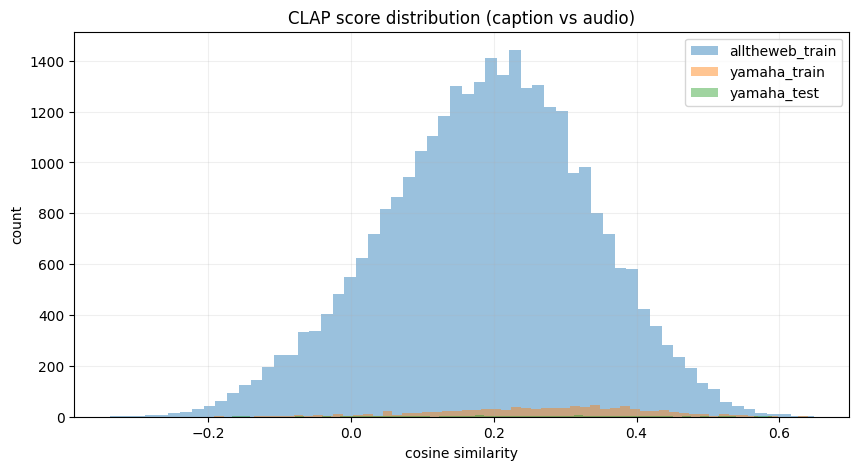

In [34]:
plt.figure(figsize=(10, 5))

bins = 60
for name, run in runs.items():
    if "clap_score" not in run:
        continue
    scores = run["clap_score"].astype(float)
    plt.hist(scores, bins=bins, alpha=0.45, label=name)

plt.title("CLAP score distribution (caption vs audio)")
plt.xlabel("cosine similarity")
plt.ylabel("count")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


In [35]:
def tsne_2d(
    emb: np.ndarray,
    meta: pd.DataFrame,
    *,
    sample_n: int = 4000,
    pca_dim: int = 50,
    perplexity: int = 30,
    random_state: int = 0,
) -> pd.DataFrame:
    if emb.shape[0] != len(meta):
        raise ValueError(f"Embedding rows ({emb.shape[0]}) != meta rows ({len(meta)})")

    rng = np.random.RandomState(random_state)
    n = emb.shape[0]
    idx = np.arange(n)
    if sample_n < n:
        idx = rng.choice(idx, size=sample_n, replace=False)

    x = emb[idx].astype(np.float32)

    # PCA before t-SNE for speed/stability.
    n_components = min(pca_dim, x.shape[1], x.shape[0] - 1)
    x = PCA(n_components=n_components, random_state=random_state).fit_transform(x)

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        init="pca",
        learning_rate="auto",
        random_state=random_state,
    )
    xy = tsne.fit_transform(x)

    out = meta.iloc[idx].copy()
    out["tsne_x"] = xy[:, 0]
    out["tsne_y"] = xy[:, 1]
    return out


def plot_tsne(df_xy: pd.DataFrame, *, title: str, color_col: str = "run") -> None:
    plt.figure(figsize=(9, 7))
    for label, sub in df_xy.groupby(color_col):
        plt.scatter(sub["tsne_x"], sub["tsne_y"], s=6, alpha=0.65, label=str(label))
    plt.title(title)
    plt.legend(markerscale=3)
    plt.grid(True, alpha=0.2)
    plt.show()


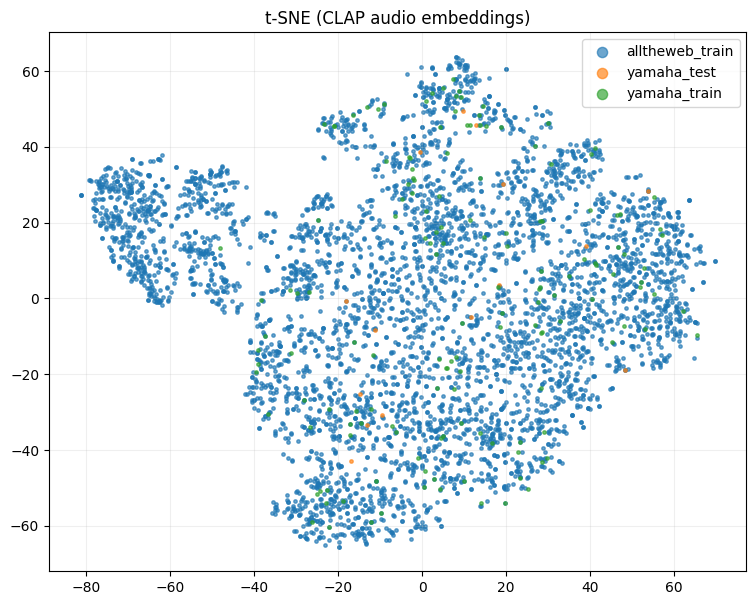

In [36]:
# t-SNE: CLAP audio embeddings

clap_emb_parts = []
clap_meta_parts = []
for name, run in runs.items():
    if "clap_audio_emb" not in run:
        continue
    clap_emb_parts.append(run["clap_audio_emb"])
    clap_meta_parts.append(attach_columns(name, run))

if clap_emb_parts:
    clap_emb_all = np.concatenate(clap_emb_parts, axis=0)
    clap_meta_all = pd.concat(clap_meta_parts, ignore_index=True)

    df_xy = tsne_2d(clap_emb_all, clap_meta_all, sample_n=5000, perplexity=35, random_state=0)
    plot_tsne(df_xy, title="t-SNE (CLAP audio embeddings)")
else:
    print("No CLAP audio embeddings were found in loaded runs.")


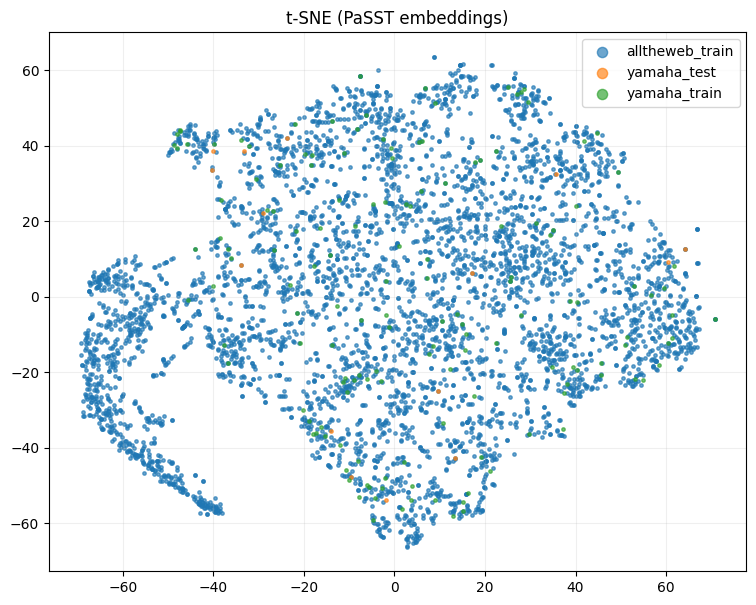

In [37]:
# t-SNE: PaSST embeddings

passt_emb_parts = []
passt_meta_parts = []
for name, run in runs.items():
    if "passt_emb" not in run:
        continue
    passt_emb_parts.append(run["passt_emb"])
    passt_meta_parts.append(attach_columns(name, run))

if passt_emb_parts:
    passt_emb_all = np.concatenate(passt_emb_parts, axis=0)
    passt_meta_all = pd.concat(passt_meta_parts, ignore_index=True)

    df_xy = tsne_2d(passt_emb_all, passt_meta_all, sample_n=5000, perplexity=35, random_state=0)
    plot_tsne(df_xy, title="t-SNE (PaSST embeddings)")
else:
    print("No PaSST embeddings were found in loaded runs.")


,run,id,name,wav_path,clap_score,caption
22,yamaha_test,243,TapeRewnd,DX7_YAMAHA/VRC Voice ROMs/vrc110b/30_TapeRewnd...,-0.056170,"Tape effect, which features distinct pitch gli..."
16,yamaha_test,157,BIRD,DX7_YAMAHA/VRC Voice ROMs/vrc105b/7_BIRD .wav,-0.017033,"Pizzicato string instrument, which has a deep,..."
27,yamaha_test,293,NORMAL ST,DX7_YAMAHA/VRC Voice ROMs/vrc109b/18_NORMAL ST...,-0.000048,"Plucked string instrument, which has a bright,..."
32,yamaha_test,353,MAC.GUN,DX7_YAMAHA/VRC Voice ROMs/vrc105a/14_MAC.GUN ...,0.022109,"Electronic percussive effect, which has a shar..."
5,yamaha_test,46,-D- TALK.,DX7_YAMAHA/GreyMatter E! Card/5/15_-D- TALK..wav,0.022364,"Vocal pad, which has a deep, resonant, and som..."
3,yamaha_test,32,IceCaves,DX7_YAMAHA/GreyMatter E! Card/5/1_IceCaves.wav,0.038746,"Ethereal pad, which has a cold, glassy, and re..."
86,yamaha_test,873,GRAND PRI,DX7_YAMAHA/Factory patches/rom3a/27_GRAND PRI.wav,0.051536,"Piano, which has a percussive, bright timbre w..."
15,yamaha_test,148,Handrum,DX7_YAMAHA/VRC Voice ROMs/vrc107b/30_Handrum ...,0.051966,"Hand drum, which has a sharp, percussive attac..."
28,yamaha_test,322,MutronClv,DX7_YAMAHA/VRC Voice ROMs/vrc111a/15_MutronClv...,0.063306,"Clavinet, which has a percussive attack and a ..."
72,yamaha_test,789,DX Additv,DX7_YAMAHA/VRC Voice ROMs/vrc111b/7_DX Additv.wav,0.081746,"Marimba, which has a percussive, clear attack ..."


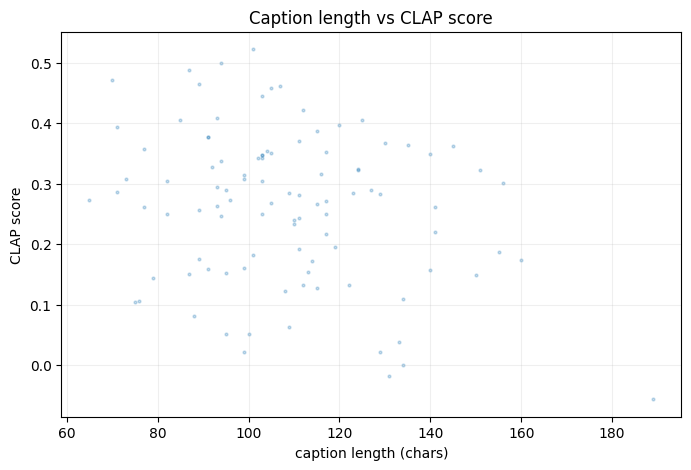

In [18]:
if "clap_score" in df_all.columns:
    display(
        df_all.sort_values("clap_score", ascending=True)
        .head(25)[[c for c in ["run", "id", "name", "wav_path", "clap_score", "caption"] if c in df_all.columns]]
    )

    plt.figure(figsize=(8, 5))
    plt.scatter(df_all["caption_len"], df_all["clap_score"], s=4, alpha=0.25)
    plt.title("Caption length vs CLAP score")
    plt.xlabel("caption length (chars)")
    plt.ylabel("CLAP score")
    plt.grid(True, alpha=0.2)
    plt.show()
